## Linguistic analysis of Flickr data
#### This notebook contains the code used to run the linguistic analysis section of our article. Specifically, the language of a subsection of the posts is determined and the most important words found in the posts are determined using word count and tf-idf methods.

##### Dependencies:
- Pandas
- Geopandas
- Matplotlib.pyplot
- Gensim
- NLTK
- Langdetect (Python implementation)

In [1]:
import geopandas as gpd
import pandas as pd
from langdetect import detect, detect_langs
import re, string
import matplotlib.pyplot as plt
import gensim as gm
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords

### Text preprocessing

Reading in a geopackage containing all of the Flickr posts in the dataset

In [3]:
geo_data = gpd.read_file("C:\\path_to_file\\flickr_cleaned.gpkg")

KeyboardInterrupt: 

In [9]:
# transforming to non-spatial form, because GDF caused some troubles
data = pd.DataFrame(geo_data)

In [44]:
def regex_check(text):
    """This function takes in a string and returns true if the string passes all the requirements
    These are:
    1. The string is long enough (more than 15 characters)
    2. It's not just an url
    3. It's not just a default filename
    These rules were found to clean up at least most of the useless noise."""

    len_check = len(text) < 15
    url_check = re.search(r'(http|ftp|https)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?$', text)
    num_check = re.search(r'\d{5,}', text)
    img_check = re.search(r'IMG\.', text)
    filetype_check = re.search(r'(\.jpg$|\.png$)', text)
    
    # if any of these previous checks were true the string has failed. Return false
    if url_check or len_check or num_check or img_check or filetype_check:
        return False
    else:
        return True

In [65]:
prev_text = ""
desc_checks = []
# loop through the description column. For each string, produce either true or false
# add these booleans to a list
for text in data['description']:
    # the text might be missing
    if not text:
        desc_checks.append(False)
    # or be a duplicate
    elif text==prev_text:
        desc_checks.append(False)
        prev_text=text
    # else, run it through regex checks above
    else:
        check = regex_check(text)
        desc_checks.append(check)
        prev_text=text

In [66]:
# text seemed to be found in the title as well. Repeat the process
prev_text = ""
title_checks = []
for text in data['title']:
    #print(text)
    if not text:
        title_checks.append(False)
    elif text==prev_text:
        title_checks.append(False)
        prev_text=text
    else:
        check = regex_check(text)
        title_checks.append(check)
        prev_text=text
    

In [67]:
# exploring the data
print(desc_checks[:150])

[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, True, True, True, True, False, False, False, True, True, False, True, True, False, True, False, False, False, False, False, False, False, False, False, False, True, True, True, True, False, False, False, False, False, False, False, False, False, True, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, False, False, False, False,

In [56]:
len(desc_checks)

2333550

In [68]:
# the lists are the same length as the columns
# therefore, they can be defined as columns easily
data['title_check'] = title_checks
data['desc_check'] = desc_checks

In [70]:
# checking out the data
data.head(40)

,id,title,description,date_taken,date_posted,filename,page_url,photo_url,photo_hash,lat,...,user_id,user_name,user_realname,user_location,media,media_downloaded,kba_bbox,geometry,title_check,desc_check
0,46131699642,Socorro Trip 2018,,2018-11-28T17:41:09,2018-12-05T01:58:38,46131699642_37f4bae166_m.jpg,,https://farm5.staticflickr.com/4861/4613169964...,None,18.992500,...,54091131@N00,W.Worresch,,,None,False,"-140.0000000000,-10.0000000000,-110.0000000000...",POINT (-112.0775 18.9925),True,False
1,31243073717,Socorro Trip 2018,,2018-11-27T16:17:48,2018-12-05T01:58:53,31243073717_7edb315d02_m.jpg,,https://farm5.staticflickr.com/4812/3124307371...,None,18.724444,...,54091131@N00,W.Worresch,,,None,False,"-140.0000000000,-10.0000000000,-110.0000000000...",POINT (-110.917223 18.724444),False,False
2,41560051605,20171129-032,,2017-11-29T11:14:40,2018-05-31T01:37:30,41560051605_e26a2265b1_m.jpg,,https://farm2.staticflickr.com/1743/4156005160...,None,19.322105,...,7198447@N03,Justin Beevor,,,None,False,"-140.0000000000,-10.0000000000,-110.0000000000...",POINT (-110.817413 19.322105),False,False
3,18562645474,Silvertip shark (Carcharhinus albimarginatus),,2015-06-19T08:46:44,2015-06-26T23:48:10,18562645474_0644d391a2_m.jpg,,https://farm4.staticflickr.com/3928/1856264547...,None,18.999812,...,67374204@N00,Elias Levy,,,None,False,"-140.0000000000,-10.0000000000,-110.0000000000...",POINT (-112.067123 18.999812),True,False
4,18562612074,Yellowfin tuna (Thunnus albacares),,2015-06-18T16:21:38,2015-06-26T23:46:35,18562612074_1b5427f789_m.jpg,,https://farm1.staticflickr.com/485/18562612074...,None,18.999812,...,67374204@N00,Elias Levy,,,None,False,"-140.0000000000,-10.0000000000,-110.0000000000...",POINT (-112.067123 18.999812),True,False
5,18997434730,Whitetip reef shark (Triaenodon obesus),,2015-06-18T13:03:30,2015-06-26T23:45:23,18997434730_4f6a919626_m.jpg,,https://farm1.staticflickr.com/560/18997434730...,None,18.999812,...,67374204@N00,Elias Levy,,,None,False,"-140.0000000000,-10.0000000000,-110.0000000000...",POINT (-112.067123 18.999812),True,False
6,18564468653,Yellowfin tuna (Thunnus albacares),,2015-06-18T12:25:59,2015-06-26T23:43:54,18564468653_6641bbeb61_m.jpg,,https://farm1.staticflickr.com/536/18564468653...,None,18.999812,...,67374204@N00,Elias Levy,,,None,False,"-140.0000000000,-10.0000000000,-110.0000000000...",POINT (-112.067123 18.999812),True,False
7,19188611381,Bigeye Trevally (Caranx sexfasciatus),,2015-06-17T09:28:34,2015-06-26T23:41:15,19188611381_60cd8c9abe_m.jpg,,https://farm1.staticflickr.com/424/19188611381...,None,18.999812,...,67374204@N00,Elias Levy,,,None,False,"-140.0000000000,-10.0000000000,-110.0000000000...",POINT (-112.067123 18.999812),True,False
8,18997449238,Roca Partida,,2015-06-17T07:19:09,2015-06-26T23:40:49,18997449238_9c4f645eec_m.jpg,,https://farm1.staticflickr.com/264/18997449238...,None,18.999812,...,67374204@N00,Elias Levy,,,None,False,"-140.0000000000,-10.0000000000,-110.0000000000...",POINT (-112.067123 18.999812),False,False
9,45269792815,Socorro Trip 2018,,2018-11-25T12:08:36,2018-12-05T01:58:43,45269792815_0c10e35d2a_m.jpg,,https://farm5.staticflickr.com/4831/4526979281...,None,19.455000,...,54091131@N00,W.Worresch,,,None,False,"-140.0000000000,-10.0000000000,-110.0000000000...",POINT (-110.761945 19.455),True,False


In [78]:
# checking out in how many posts the title text has passed these requirements
titles = data.loc[data['title_check']].copy()
len(titles)

In [79]:
# repeat for description
descs = data.loc[data['desc_check']].copy()
len(descs)

702841

In [75]:
# creating a new dataframe where the checks are true for both columns.
# Different approaches could be taken here: we decided to combine these 
# columns in the end and thus create a larger text item to study
titles_n_desc = data.loc[data['title_check'] & data['desc_check']].copy()

In [161]:
# some of the rows (about 10, I think) produced faulty results...
# they were manually dropped. Should've kept all the dropped rows, damn
# now it must be done again, unless the premade geodataframe is not used
titles_n_desc = titles_n_desc.drop([1001545])

In [167]:
# this is how many posts are left
len(titles_n_desc)

227426

In [24]:
# creating a geodataframe
titles_n_desc_geo = gpd.GeoDataFrame(titles_n_desc, crs=geo_data.crs, geometry='geometry')

NameError: name 'geo_data' is not defined

In [90]:
# dropping useless columns
titles_n_desc_geo = titles_n_desc_geo.drop(columns=['media_downloaded', 'title_check', 'desc_check'])

In [25]:
# writing to geopackage
titles_n_desc.to_file("C:\\Users\\joker\\gis_proggikset\\flickr_titles_desc.gpkg",driver="GPKG")

CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_flickr_titles_desc_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'

Exception ignored in: 'fiona._shim.gdal_flush_cache'
Traceback (most recent call last):
  File "fiona/_err.pyx", line 201, in fiona._err.GDALErrCtxManager.__exit__
fiona._err.CPLE_AppDefinedError: b'sqlite3_exec(CREATE VIRTUAL TABLE "rtree_flickr_titles_desc_geom" USING rtree(id, minx, maxx, miny, maxy)) failed: no such module: rtree'


AttributeError: 'str' object has no attribute '__geo_interface__'

In [2]:
# reading back the gpkg
titles_n_desc = gpd.read_file("C:\\Users\\joker\\gis_proggikset\\flickr_titles_desc.gpkg")

### Language identification

In [4]:
def lang_detection(text):
    """This function is fed a string and it returns a string that tells
    1. Two letter code marking the language identified
    2. String 'null', if the identification turned out to be uncertain"""
    languages = detect_langs(text)
    
    if languages[0].prob >= 0.85:
        return languages[0].lang
    else:
        return 'null'
    

In [6]:
languages = []
# looping through titles and descriptions
for title, desc in zip(titles_n_desc['title'], titles_n_desc['description']):
    # removing useless whitespace
    if desc.strip():
        full_text = title + " " + desc
        # in case there isn't any text
        if full_text:
            detected_language = lang_detection(full_text)
    
            languages.append(detected_language)
        else:
            languages.append('null')
    else:
        languages.append('null')

In [27]:
# so as to not run this code repeatedly when reopening, write the results to a list
with open("languages_list.txt", "w") as f:
    for item in languages:
        f.write("%s\n" % str(item))

In [6]:
# see unique languages
print(set(languages))

{'cs', 'no', 'fr', 'ko', 'hr', 'pt', 'zh-tw', 'ja', 'da', 'sw', 'bg', 'af', 'ca', 'vi', 'th', 'ru', 'fi', 'hu', 'tr', 'nl', 'es', 'mr', 'id', 'null', 'pl', 'uk', 'mk', 'so', 'sv', 'en', 'zh-cn', 'it', 'de', 'ar', 'ro', 'sk', 'cy', 'lv', 'he', 'el', 'tl', 'et', 'sq', 'sl', 'lt'}


In [22]:
titles_n_desc['lang'] = languages

In [15]:
titles_n_desc.tail(50)

,id,title,description,date_taken,date_posted,filename,page_url,photo_url,photo_hash,lat,...,geo_region,geo_country,user_id,user_name,user_realname,user_location,media,kba_bbox,geometry,lang
227384,32996732358,Drei Birkennüsse für Hocksteinbesucher,Nussfrüchte einer Hängebirke auf der Hockstein...,2019-01-22T12:10:19,2019-01-25T17:04:29,32996732358_3c4bf17ce1_m.jpg,,https://farm8.staticflickr.com/7866/3299673235...,None,50.9803,...,,,147756367@N08,Christoph Bieberstein,,,None,"0.0000000000,50.0000000000,20.0000000000,70.00...",POINT (14.10196 50.980256),de
227385,46154902904,Burgwarte auf dem Frindsberg,"Auf dem schmalen Felsrücken, der Polenztal und...",2019-01-26T00:30:05,2019-01-26T10:46:55,46154902904_f914e0ab7e_m.jpg,,https://farm5.staticflickr.com/4831/4615490290...,None,50.9491,...,,,147756367@N08,Christoph Bieberstein,,,None,"0.0000000000,50.0000000000,20.0000000000,70.00...",POINT (14.133932 50.949079),de
227386,46885014221,WinterSport in den Maasduinen,OLYMPUS DIGITAL CAMERA\n\n,2019-01-23T15:22:51,2019-01-26T21:05:35,46885014221_4909568c88_m.jpg,,https://farm8.staticflickr.com/7880/4688501422...,None,51.5218,...,,,65133909@N07,moni-h,,,None,"0.0000000000,50.0000000000,20.0000000000,70.00...",POINT (6.164236 51.521836),de
227387,46828738132,2019-01-19 11-45-40 - IMGP7880,Blick auf Torfhaus,2019-01-19T11:45:40,2019-01-26T13:23:01,46828738132_83b0b2bbd4_m.jpg,,https://farm5.staticflickr.com/4879/4682873813...,None,51.8008,...,,,157710372@N02,Schremserfrank,,,None,"0.0000000000,50.0000000000,20.0000000000,70.00...",POINT (10.610122 51.800755),de
227388,46155923604,2019-01-19 11-40-52 - IMGP7869,Goetheweg und Blick auf den Wurmberg,2019-01-19T11:40:52,2019-01-26T13:22:20,46155923604_b6d9b1a603_m.jpg,,https://farm8.staticflickr.com/7845/4615592360...,None,51.7932,...,,,157710372@N02,Schremserfrank,,,None,"0.0000000000,50.0000000000,20.0000000000,70.00...",POINT (10.619663 51.793227),de
227389,31939511077,2019-01-19 11-38-56 - IMGP7867,1000 m über dem Meer.,2019-01-19T11:38:56,2019-01-26T13:21:52,31939511077_ef388cb069_m.jpg,,https://farm8.staticflickr.com/7905/3193951107...,None,51.7932,...,,,157710372@N02,Schremserfrank,,,None,"0.0000000000,50.0000000000,20.0000000000,70.00...",POINT (10.60823 51.793194),de
227390,46880807021,2019-01-19 11-35-27 - IMGP7865,Ausweichgleis am Goethe-Weg\n,2019-01-19T11:35:27,2019-01-26T13:21:41,46880807021_c03130d73d_m.jpg,,https://farm8.staticflickr.com/7893/4688080702...,None,51.7878,...,,,157710372@N02,Schremserfrank,,,None,"0.0000000000,50.0000000000,20.0000000000,70.00...",POINT (10.593822 51.787777),de
227391,39929842303,Kurzbesuch beim Paten am Taufstein,kleiner Spaziergang am Freitagnachmittag im Ba...,2019-01-25T17:33:49,2019-01-27T17:55:19,39929842303_927596e331_m.jpg,,https://farm5.staticflickr.com/4813/3992984230...,None,50.9627,...,,,131418754@N05,https://www.norbert-kaiser-foto.de/,,,None,"0.0000000000,50.0000000000,20.0000000000,70.00...",POINT (14.073143 50.962731),de
227392,39927541853,Calypso. Aquafibre 38 lowliner.,Built as Fairliner 1 for the hire fleet of Fai...,2019-01-11T11:21:30,2019-01-27T14:08:25,39927541853_32fb06254b_m.jpg,,https://farm5.staticflickr.com/4806/3992754185...,None,52.6782,...,,,28990133@N06,Fred Collins afloat and ashore,,,None,"0.0000000000,50.0000000000,20.0000000000,70.00...",POINT (1.489118 52.678175),en
227393,31951126587,Emerald Lady. Aquafibre 38 lowliner.,Seen in icy conditions at her home moorining i...,2019-01-20T13:31:53,2019-01-27T14:08:25,31951126587_a6f2e8e52b_m.jpg,,https://farm8.staticflickr.com/7911/3195112658...,None,52.695,...,,,28990133@N06,Fred Collins afloat and ashore,,,None,"0.0000000000,50.0000000000,20.0000000000,70.00...",POINT (1.47132 52.694976),en


In [82]:
# subset with only recognized languages
no_null = titles_n_desc.loc[titles_n_desc['lang'] != 'null'].copy()

In [13]:
# for plotting purposes
major_languages = ['en', 'es', 'it', 'de', 'null']

In [84]:
# if not one of the large languages, a new value is defined for those rows
no_null.loc[no_null['lang'].isin(major_languages) == False] = 'other'

In [16]:
titles_n_desc.loc[titles_n_desc['lang'].isin(major_languages) == False] = 'other'

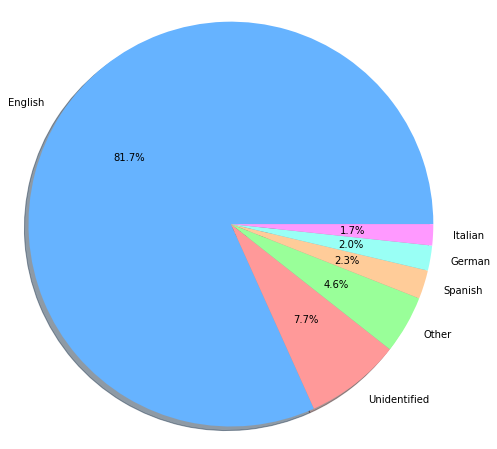

In [21]:
labels = ['English', 'Unidentified', 'Other', 'Spanish', 'German', 'Italian']
colors = ['#66b3ff', '#ff9999','#99ff99','#ffcc99', '#99fff5', '#ff99ff']
# plot either this or the 'no_null' dataframe
ax = titles_n_desc['lang'].value_counts().plot(kind='pie', colors=colors, figsize=(8,8), labels=labels,
                                   autopct='%1.1f%%', shadow=True)
plt.axis('equal')
ax.yaxis.set_visible(False)
plt.savefig("lang_piechart.png")

### Word analysis

In [133]:
# fetch rows identified as english
english_sents = titles_n_desc.loc[titles_n_desc['lang'] == 'en'].copy()

In [193]:
sents = []
i = 0
# NOTE!!! English sentences analyzed, change "english sents" to "titles_n_desc" for full dataset examination
for title, desc in zip(english_sents['title'], english_sents['description']):
    if desc.strip():
        full_text = title + " " + desc
        # add all the tokenized (split to individual words) words. Uncommented version filters for useless characters
        split_text = [word.lower() for word in word_tokenize(full_text)]
        #split_text = [word.lower() for word in word_tokenize(full_text) if word.isalpha()]
        
        sents.append(split_text)


In [194]:
# sentences to gensim dictionary
words_dictionary = gm.corpora.Dictionary(sents)
# remove extremely uncommon and common words
words_dictionary.filter_extremes(no_below=2, no_above=0.6)

# dictionary to corpus
corpus = [words_dictionary.doc2bow(doc,allow_update=False) for doc in sents]
#dct = gm.corpora.Dictionary(corpus)
#corpus.filter_extremes(no_below=2, no_above=0.6)

In [195]:
# applying tf-idf
tfidf = gm.models.TfidfModel(corpus, smartirs='lfc')

In [190]:
# key figures
print(tfidf)

TfidfModel(num_docs=224774, num_nnz=5325789)


In [196]:
i = 0
d = {}
# filling out a dictionary where the word is the key and the tf-idf score is the value
for doc in tfidf[corpus]:
    for ident, value in doc:
        word = words_dictionary.get(ident)
        d[word] = value
    #i += 1
    #if i == 1000:
        #print([[words_dictionary[ident], round(freq, 2)] for ident, freq in doc])
        #break

In [197]:
# printing out the words that got the highest tf-idf scores
print({k: round(v, 3) for k, v in sorted(d.items(), key=lambda item: item[1]) if v>0.8})

{'jolie': 0.8, 'niggerheads': 0.8, 'twentymile': 0.801, 'nasu': 0.801, 'phiala': 0.801, 'footstool': 0.801, 'ndlovu': 0.801, 'belgian': 0.801, 'corporal': 0.801, 'histurgops': 0.801, 'ohi': 0.801, 'wizards': 0.802, 'dargo': 0.802, 'vieste': 0.802, 'snowdrift': 0.802, 'tiveden': 0.802, 'sleds': 0.802, 'crossandra': 0.802, 'lubec': 0.802, 'tawhai': 0.803, 'swirley': 0.803, 'shoshoni': 0.803, 'barcoo': 0.803, 'chinaman': 0.803, 'blutkuppe': 0.803, 'mardale': 0.804, 'snowbirds': 0.804, 'culmination': 0.804, 'refugees': 0.804, 'aquacourt': 0.805, 'hora': 0.805, 'cathy': 0.805, 'talon': 0.805, 'mikey': 0.805, 'meadowlark': 0.805, 'resurrection': 0.805, 'lacrymosa': 0.806, 'shutlingsloe': 0.806, 'cobbler': 0.806, 'domogled': 0.806, 'tshanga': 0.806, 'terrier': 0.806, 'amit': 0.806, 'vulnerata': 0.806, 'redrock': 0.807, 'emeric': 0.807, 'wanggoolba': 0.807, 'dicksons': 0.807, 'formosan': 0.807, 'interglacier': 0.808, 'trumpetfish': 0.808, 'cowfish': 0.808, 'providential': 0.808, 'idaea': 0.808

In [199]:
# word count method below
major_languages = ['english', 'spanish', 'french', 'italian']
# custom stop words
swords = ['http', 'em', 'quot', 'nofollow', 'com', 'é']

# adding stop words (words with little semantic relevance)
# to a list. Stopwords provided by NLTK
for lang in major_languages:
    lang_swords = stopwords.words(lang)
    for word in lang_swords:
        # adding normal and capitalized version too
        swords.append(word)
        swords.append(word.capitalize())

In [200]:
# filtering for stopwords
# 
flat_list = [item.lower() for sublist in sents for item in sublist if item not in swords]

In [201]:
# nltk gives a handy frequency distribution class
fdist = FreqDist(flat_list)

In [202]:
print(fdist)

<FreqDist with 99930 samples and 3900136 outcomes>


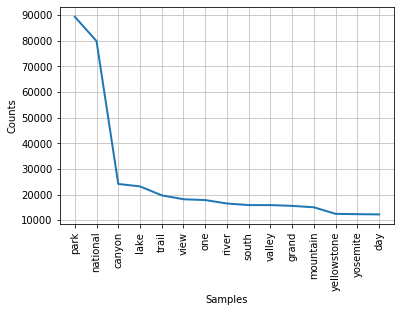

In [203]:
fdist.plot(15)